In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [ ]:
import os
import random
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DATA_ROOT = "/content/drive/MyDrive/DeepLearning"

TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

In [ ]:
transform_lenet_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_lenet_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [ ]:
transform_imagenet_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])

transform_imagenet_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])


In [ ]:
BATCH_SIZE = 32
# NUM_WORKERS = 2

train_ds_lenet = datasets.ImageFolder(root=TRAIN_DIR, transform=transform_lenet_train)
test_ds_lenet  = datasets.ImageFolder(root=TEST_DIR,  transform=transform_lenet_test)

train_ds_im = datasets.ImageFolder(root=TRAIN_DIR, transform=transform_imagenet_train)
test_ds_im  = datasets.ImageFolder(root=TEST_DIR,  transform=transform_imagenet_test)

train_loader_lenet = DataLoader(train_ds_lenet, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader_lenet  = DataLoader(test_ds_lenet, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_loader_im = DataLoader(train_ds_im, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader_im  = DataLoader(test_ds_im, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

class_names = train_ds_lenet.classes
print("Classes:", class_names)


Classes: ['Cat', 'Dog']


In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool  = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)


In [ ]:
def build_model(name, num_classes=2, pretrained=True):
    name = name.lower()

    if name == "alexnet":
        m = models.alexnet(weights=models.AlexNet_Weights.DEFAULT if pretrained else None)
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes)

    elif name == "vgg16":
        m = models.vgg16(weights=models.VGG16_Weights.DEFAULT if pretrained else None)
        m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes)

    elif name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        m.fc = nn.Linear(m.fc.in_features, num_classes)

    elif name == "inception":
        m = models.inception_v3(
            weights=models.Inception_V3_Weights.DEFAULT if pretrained else None,
            aux_logits=True
        )
        m.fc = nn.Linear(m.fc.in_features, num_classes)
        m.AuxLogits.fc = nn.Linear(m.AuxLogits.fc.in_features, num_classes)

    else:
        raise ValueError("Unknown model")

    return m


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_one_model(model, train_loader, test_loader, epochs=5, lr=1e-4, name="model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "test_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(imgs)

            if isinstance(outputs, tuple):
                main_out, aux_out = outputs
                loss = criterion(main_out, labels) + 0.4 * criterion(aux_out, labels)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            total += labels.size(0)

        avg_loss = running_loss / total
        acc = evaluate(model, test_loader)

        history["train_loss"].append(avg_loss)
        history["test_acc"].append(acc)

        print(f"{name} | Epoch {epoch+1}/{epochs} | Loss {avg_loss:.4f} | Test Acc {acc:.4f}")

    return history


In [ ]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total


In [ ]:
EPOCHS = 5
results = {}

# LeNet
lenet = LeNet5(num_classes=2)
results["LeNet5"] = train_one_model(
    lenet, train_loader_lenet, test_loader_lenet,
    epochs=EPOCHS, lr=1e-3, name="LeNet5"
)

# ImageNet style models
for arch in ["alexnet", "vgg16", "resnet18", "inception"]:
    model = build_model(arch, num_classes=2, pretrained=True)
    results[arch.upper()] = train_one_model(
        model, train_loader_im, test_loader_im,
        epochs=EPOCHS, lr=1e-4, name=arch.upper()
    )


LeNet5 | Epoch 1/5 | Loss 0.6930 | Test Acc 0.5550
LeNet5 | Epoch 2/5 | Loss 0.6801 | Test Acc 0.4950
LeNet5 | Epoch 3/5 | Loss 0.6719 | Test Acc 0.5800
LeNet5 | Epoch 4/5 | Loss 0.6507 | Test Acc 0.5900
LeNet5 | Epoch 5/5 | Loss 0.6399 | Test Acc 0.6150
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 96.7MB/s]


ALEXNET | Epoch 1/5 | Loss 0.2152 | Test Acc 0.9300
ALEXNET | Epoch 2/5 | Loss 0.0907 | Test Acc 0.9700
ALEXNET | Epoch 3/5 | Loss 0.0330 | Test Acc 0.9900
ALEXNET | Epoch 4/5 | Loss 0.0098 | Test Acc 0.9900
ALEXNET | Epoch 5/5 | Loss 0.0063 | Test Acc 0.9800
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 72.7MB/s]


VGG16 | Epoch 1/5 | Loss 0.1705 | Test Acc 0.9550


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt


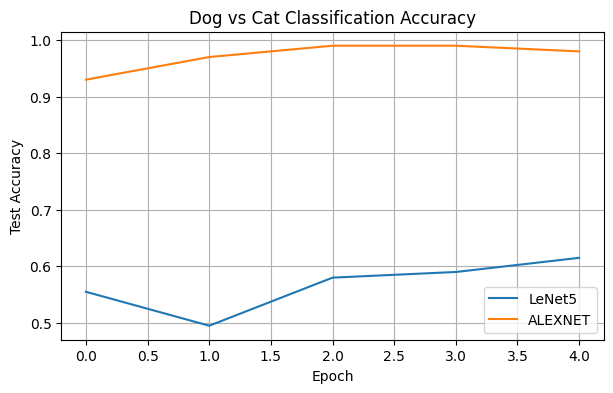

In [ ]:
plt.figure(figsize=(7,4))
for name, hist in results.items():
    plt.plot(hist["test_acc"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Dog vs Cat Classification Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
lenet

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import pandas as pd


In [ ]:
@torch.no_grad()
def get_predictions(model, loader):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []  # probability for positive class (dog)

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)

        # Handle Inception output
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # class 1 probability

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()


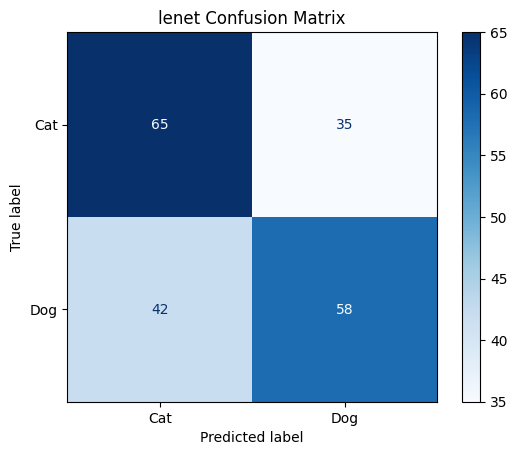

In [ ]:
labels, preds, probs = get_predictions(lenet, test_loader_lenet)

plot_confusion_matrix(
    labels,
    preds,
    class_names=["Cat", "Dog"],
    title="lenet Confusion Matrix"
)


In [ ]:
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [ ]:
plot_roc_curve(
    labels,
    probs,
    title="LeNet ROC Curve"
)


In [ ]:
trained_models = {
    "LeNet5": lenet,
    # "AlexNet": alexnet_model,
    # "VGG16": vgg16_model,
    # "ResNet18": resnet_model,
    # "Inception": inception_model
}


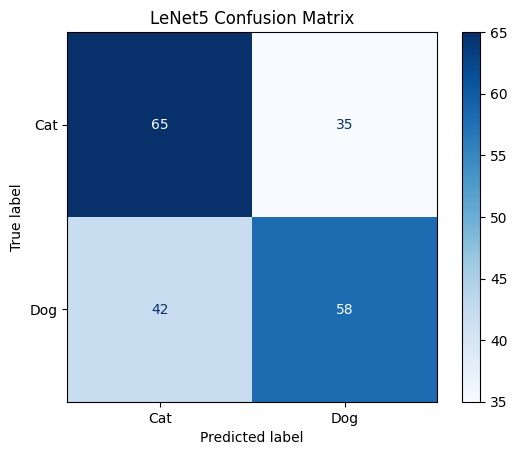

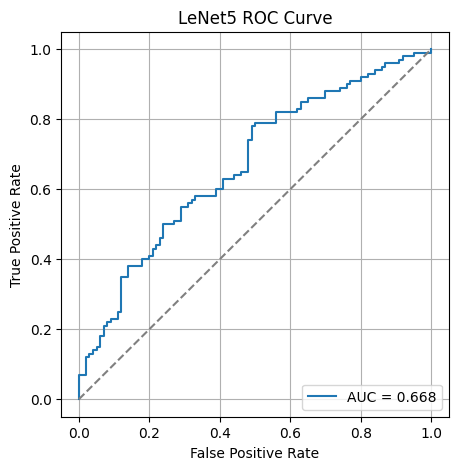

In [ ]:
for name, model in trained_models.items():
    loader = test_loader_lenet if name == "LeNet5" else test_loader_im

    y_true, y_pred, y_prob = get_predictions(model, loader)

    plot_confusion_matrix(
        y_true,
        y_pred,
        class_names=["Cat", "Dog"],
        title=f"{name} Confusion Matrix"
    )

    plot_roc_curve(
        y_true,
        y_prob,
        title=f"{name} ROC Curve"
    )


In [ ]:
def classification_metrics_table(y_true, y_pred, class_names):
    report = classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        output_dict=True
    )

    df = pd.DataFrame(report).transpose()

    # Keep only relevant rows and columns
    df = df.loc[class_names + ["accuracy"],
                ["precision", "recall", "f1-score", "support"]]

    return df


In [ ]:
labels, preds, probs = get_predictions(lenet, test_loader_lenet)

metrics_df = classification_metrics_table(
    labels,
    preds,
    class_names=["Cat", "Dog"]
)

metrics_df


,precision,recall,f1-score,support
Cat,0.607477,0.650,0.628019,100.000
Dog,0.623656,0.580,0.601036,100.000
accuracy,0.615000,0.615,0.615000,0.615


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# For ImageNet-normalized models
def unnormalize(img, mean, std):
    img = img.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img


In [ ]:
@torch.no_grad()
def show_model_predictions(
    model,
    dataset,
    class_names,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    n=6,
    title="Model Predictions"
):
    model.eval()

    indices = random.sample(range(len(dataset)), n)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        input_img = img.unsqueeze(0).to(device)

        outputs = model(input_img)
        if isinstance(outputs, tuple):  # Inception
            outputs = outputs[0]

        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        conf = probs[0, pred].item()

        img_disp = unnormalize(img.cpu(), mean, std)
        img_disp = np.clip(img_disp.permute(1,2,0).numpy(), 0, 1)

        plt.subplot(1, n, i+1)
        plt.imshow(img_disp)
        plt.axis("off")
        plt.title(
            f"GT: {class_names[label]}\n"
            f"Pred: {class_names[pred]}\n"
            f"Conf: {conf:.2f}"
        )

    plt.suptitle(title)
    plt.show()


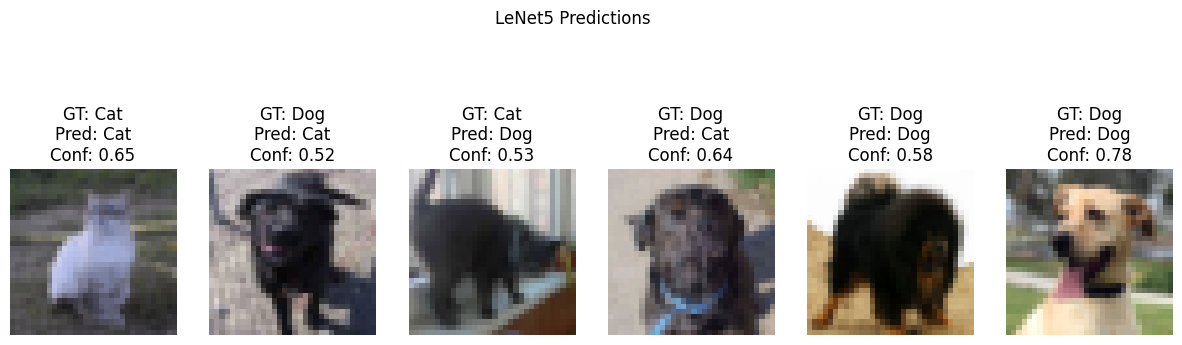

In [ ]:
show_model_predictions(
    model=lenet,
    dataset=test_ds_lenet,
    class_names=["Cat", "Dog"],
    mean=(0.5,0.5,0.5),
    std=(0.5,0.5,0.5),
    n=6,
    title="LeNet5 Predictions"
)
